<h2>Detection and Matching of Interest Points</h2>

Based on the following material:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_orb/py_orb.html
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

<h3>Inicialização</h3>

In [20]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [21]:
#https://gist.github.com/CannedYerins/11be0c50c4f78cad9549
def draw_matches(img1, kp1, img2, kp2, matches, color=None): 
    """Draws lines between matching keypoints of two images.  
    Keypoints not in a matching pair are not drawn.
    Places the images side by side in a new image and draws circles 
    around each keypoint, with line segments connecting matching pairs.
    You can tweak the r, thickness, and figsize values as needed.
    Args:
        img1: An openCV image ndarray in a grayscale or color format.
        kp1: A list of cv2.KeyPoint objects for img1.
        img2: An openCV image ndarray of the same format and with the same 
        element type as img1.
        kp2: A list of cv2.KeyPoint objects for img2.
        matches: A list of DMatch objects whose trainIdx attribute refers to 
        img1 keypoints and whose queryIdx attribute refers to img2 keypoints.
        color: The color of the circles and connecting lines drawn on the images.  
        A 3-tuple for color images, a scalar for grayscale images.  If None, these
        values are randomly generated.  
    """
    # We're drawing them side by side.  Get dimensions accordingly.
    # Handle both color and grayscale images.
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    r = 15
    thickness = 2
    if color:
        c = color
    for m in matches:
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(img1.shape) == 3 else np.random.randint(0,256)
        # So the keypoint locs are stored as a tuple of floats.  cv2.line(), like most other things,
        # wants locs as a tuple of ints.
        end1 = tuple(np.round(kp1[m.trainIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.queryIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        cv2.line(new_img, end1, end2, c, thickness)
        cv2.circle(new_img, end1, r, c, thickness)
        cv2.circle(new_img, end2, r, c, thickness)
    
    #plt.figure(figsize=(15,15))
    #plt.imshow(new_img)
    #plt.show()
    
    return new_img

In [22]:
# funções auxiliares
def show_image(img, title = '', scale = 6):
    plt.figure(figsize=(scale,scale))
    if (len(img.shape) == 3):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap = 'gray')
    plt.title(title)
    plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.show()

<h3>Harris Corner Detector</h3>

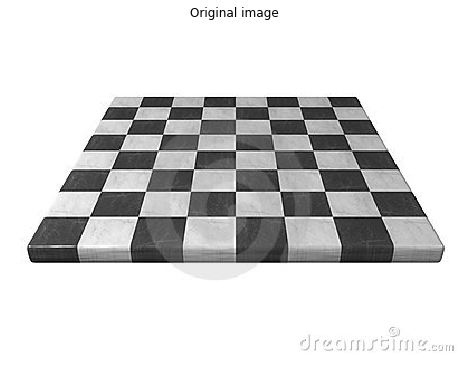

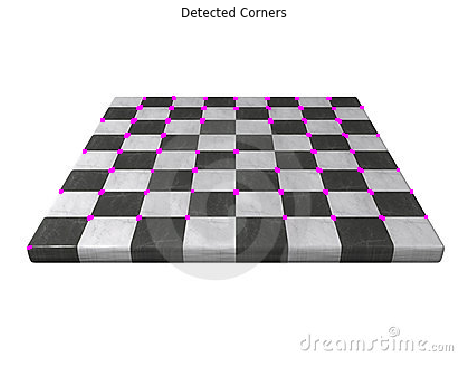

In [23]:
#filename = 'chessboard.jpg'
filename = 'cameraman.png'
#filename = 'lena.jpg'
filename = 'marble-chessboard-18795275.jpg'
#filename = 'stock-photo-chess-board-250580347.jpg'
#filename = '001_apple_tgt.png'


img = cv2.imread(filename)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.2*dst.max()]=[255,0,255]
   
show_image(gray, 'Original image', 8)    
show_image(img, 'Detected Corners', 8)    

<h3>Matching of Interest Points</h3>

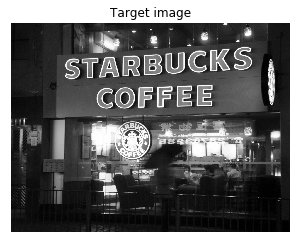

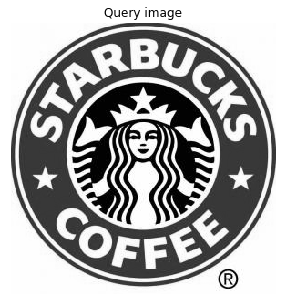

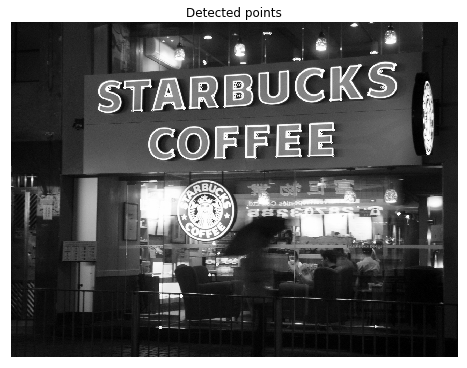

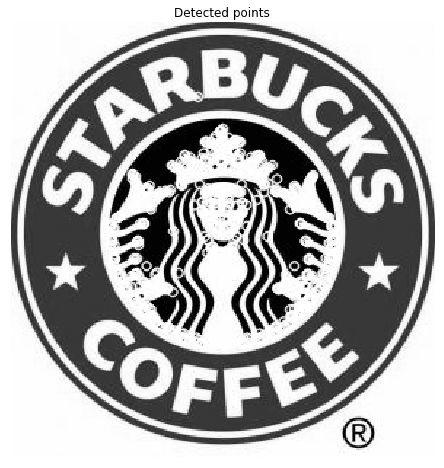

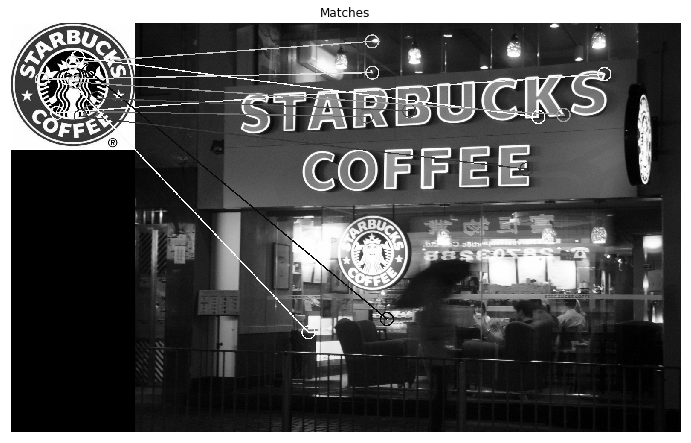

In [25]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

cv2.ocl.setUseOpenCL(False)


img1 = cv2.imread('009_coca_obj.png',0) # queryImage
img2 = cv2.imread('009_coca_tgt.png',0) # trainImage

#img1 = cv2.imread('apple-mac-logo-2.jpg',0) # queryImage
#img2 = cv2.imread('001_apple_tgt.png',0) # trainImage

img1 = cv2.imread('008_starbucks_obj.png', 0) # trainImage
img2 = cv2.imread('008_starbucks_tgt.png', 0) # queryImage


#img1 = cv2.imread('007_kay_obj.png',0) # queryImage
#img2 = cv2.imread('007_kay_tgt.png',0) # trainImage


show_image(img2, 'Target image', 5)
show_image(img1, 'Query image', 5)


# Initiate STAR detector
orb = cv2.ORB_create()

kp1 = orb.detect(img1,None)
kp2 = orb.detect(img2,None)


img3 = img2.copy()
cv2.drawKeypoints(img2,kp2,img3,color=(255,0,0), flags=1)
img4 = img1.copy()
cv2.drawKeypoints(img1,kp1,img4,color=(255,0,0), flags=1)


show_image(img3, 'Detected points', 8)
show_image(img4, 'Detected points', 8)


kp1, des1 = orb.compute(img1, kp1)
kp2, des2 = orb.compute(img2, kp2)


# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

#img5 = img1.copy()

# Draw first 10 matches.
#cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], img5)

img5 = draw_matches(img1, kp1, img2, kp2, matches[:10])


show_image(img5, 'Matches', 12)

